# Pattern Mining Exercise

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from pyECLAT import ECLAT
import time

## Data exploration
First I will load data and check the data and see what I have to work with. I will also check for any missing values.

In [147]:
groceries_df = pd.read_csv('Groceries_dataset.csv')
print(groceries_df.head())

date_range = (groceries_df['Date'].min(), groceries_df['Date'].max())
print(f"Date range: {date_range}")

groceries_df.isna().sum()

   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk
Date range: ('01-01-2014', '31-10-2015')


Member_number      0
Date               0
itemDescription    0
dtype: int64

We can see that the data consist of 3 columns with date range from 01-01-2014 till 31-10-2015 and there are no missing values in the dataset.

Next I will analyse the data.

In [148]:
pd.set_option('display.max_rows', None)
print(groceries_df.shape)

unique_members = len(groceries_df['Member_number'].unique())
unique_dates = len(groceries_df['Date'].unique())

print(f"Count of unique members: {unique_members}\nCount of unique dates: {unique_dates}\n")
grocery_counts = groceries_df['itemDescription'].value_counts()
print(f"Total number of unique items: {len(grocery_counts)}\n")

print(grocery_counts)

(38765, 3)
Count of unique members: 3898
Count of unique dates: 728

Total number of unique items: 167

itemDescription
whole milk                   2502
other vegetables             1898
rolls/buns                   1716
soda                         1514
yogurt                       1334
root vegetables              1071
tropical fruit               1032
bottled water                 933
sausage                       924
citrus fruit                  812
pastry                        785
pip fruit                     744
shopping bags                 731
canned beer                   717
bottled beer                  687
whipped/sour cream            662
newspapers                    596
frankfurter                   580
brown bread                   571
pork                          566
domestic eggs                 566
butter                        534
fruit/vegetable juice         518
beef                          516
curd                          514
margarine                     

We can see that there is total of 38765 rows from which are 3898 unique dates and 728 unique members. We also have 167 different items that the members bought. This means that I need to connect the dates with member numbers because each member will have multiple items bought on the same date.

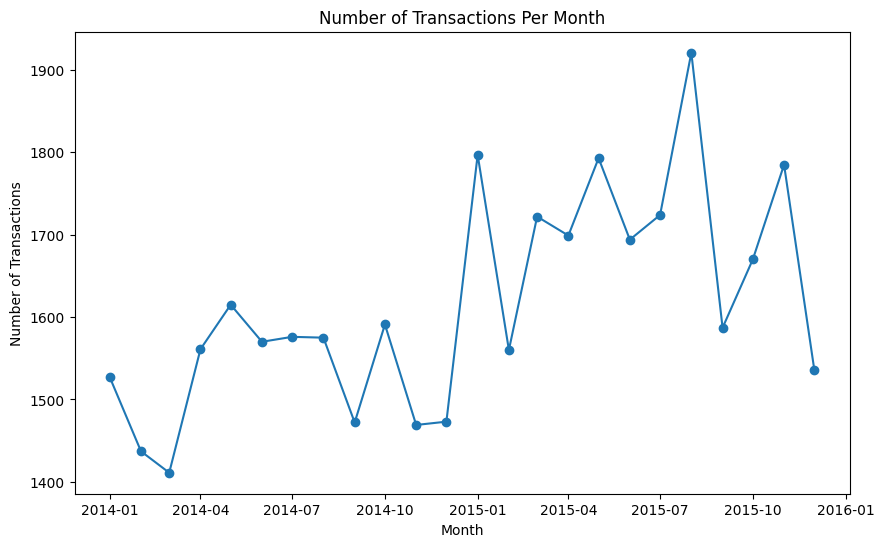

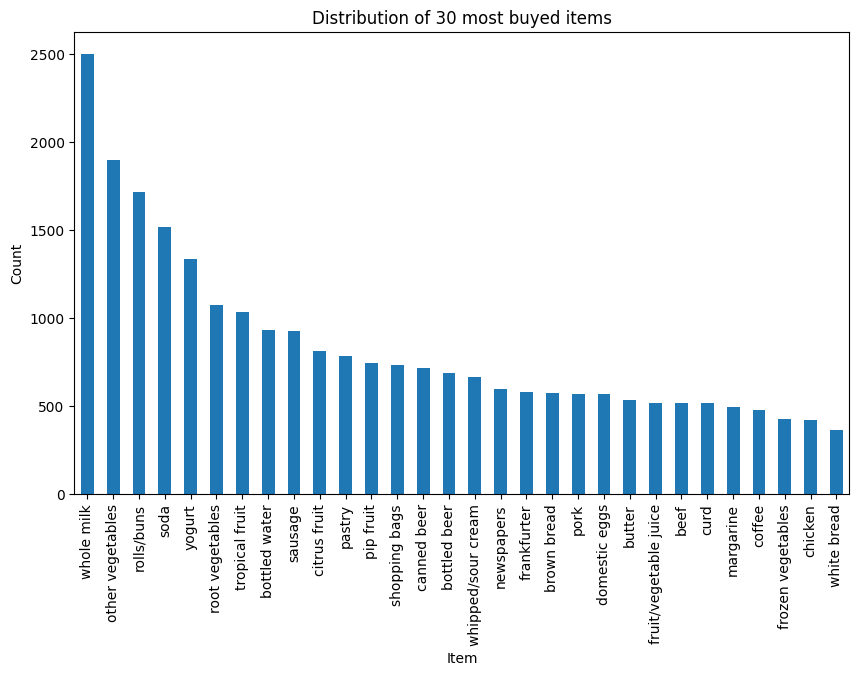

In [149]:
date_plot_df = groceries_df.copy()
date_plot_df['Date'] = pd.to_datetime(date_plot_df['Date'], dayfirst=True)

date_plot_df.set_index('Date', inplace=True)

monthly_counts = date_plot_df.resample('MS').size()

plt.figure(figsize=(10,6))
plt.plot(monthly_counts.index, monthly_counts.values, 'o-')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Per Month')
plt.show()

top_20_items = grocery_counts.nlargest(30)

plt.figure(figsize=(10,6))
top_20_items.plot(kind='bar')
plt.xlabel('Item')
plt.ylabel('Count')
plt.title('Distribution of 30 most buyed items')
plt.xticks(rotation=90)
plt.show()

We can see on the plot that shows number of transactions per month that more transactions were made in 2015 with peak in 2015-09.

On the second plot with top 30 bought items we can see the distribution of the top 30 items. We can see that the most bought item whole milk with around 2500 transactions.

In [150]:
groceries_df.itemDescription = groceries_df.itemDescription.transform(lambda x: [x])
groceries_df.itemDescription
basket = groceries_df.groupby(['Member_number', 'Date']).sum()['itemDescription'].reset_index(drop=True)
print(f"Length of transactions : {len(basket)}")
print(basket.head(10))
basket_lengths = basket.apply(len)
length_counts = basket_lengths.value_counts().sort_index()
print(f"Counts of lengths of transactions:{length_counts}")


encoder = TransactionEncoder()
transactions = pd.DataFrame(encoder.fit(basket).transform(basket), columns=encoder.columns_)
display(transactions.head())

Length of transactions : 14963
0    [sausage, whole milk, semi-finished bread, yog...
1                    [whole milk, pastry, salty snack]
2                       [canned beer, misc. beverages]
3                          [sausage, hygiene articles]
4                           [soda, pickled vegetables]
5                                  [frankfurter, curd]
6                    [sausage, whole milk, rolls/buns]
7                                   [whole milk, soda]
8                                  [beef, white bread]
9              [frankfurter, soda, whipped/sour cream]
Name: itemDescription, dtype: object
Counts of lengths of transactions:itemDescription
2     10080
3      2698
4      1390
5       344
6       175
7        80
8       145
9        50
11        1
Name: count, dtype: int64


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


First I transformed all the item descriptions to lists. Then, I have grouped the data by date and member number and created a list of items that each member bought on that date. We can see that there is total of 14963 unique transactions. I also created counts of number of items bought by each member on each date. Here we can se that most of the members bought 2 items in the groceries. I also printed the first 5 transactions (encoded) to see how the data looks like.

Now with this structure I can implement different pattern mining algorithms.

### Apriori algorithm

In [153]:
start_time = time.time()

frequent_itemsets = apriori(transactions, min_support=0.0005, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
print(frequent_itemsets.head(10))
print(frequent_itemsets.describe())

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)

time_taken = time.time()-start_time

rules_lift = rules.sort_values('lift', ascending=False)
rules_confidence = rules.sort_values('confidence', ascending=False)

print("Top 10 rules by lift:")
display(rules_lift.head(10))
print("Top 10 rules by confidence:")
display(rules_confidence.head(10))
print("Total rules: ", len(rules))

print(f"Time taken: {time_taken}")


      support            itemsets
155  0.157923        (whole milk)
97   0.122101  (other vegetables)
116  0.110005        (rolls/buns)
130  0.097106              (soda)
156  0.085879            (yogurt)
117  0.069572   (root vegetables)
147  0.067767    (tropical fruit)
10   0.060683     (bottled water)
122  0.060349           (sausage)
28   0.053131      (citrus fruit)
           support
count  1447.000000
mean      0.002983
std       0.009161
min       0.000535
25%       0.000668
50%       0.001002
75%       0.001804
max       0.157923
Top 10 rules by lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
145,(ham),(pickled vegetables),0.017109,0.008955,0.000535,0.031250,3.489506,0.000381,1.023014,0.725845
144,(pickled vegetables),(ham),0.008955,0.017109,0.000535,0.059701,3.489506,0.000381,1.045297,0.719873
118,(soft cheese),(hamburger meat),0.010025,0.021854,0.000601,0.060000,2.745505,0.000382,1.040581,0.642206
119,(hamburger meat),(soft cheese),0.021854,0.010025,0.000601,0.027523,2.745505,0.000382,1.017993,0.649973
82,"(pork, sausage)",(whole milk),0.001537,0.157923,0.000601,0.391304,2.477819,0.000359,1.383412,0.597337
83,(whole milk),"(pork, sausage)",0.157923,0.001537,0.000601,0.003809,2.477819,0.000359,1.002280,0.708272
155,(pip fruit),(sweet spreads),0.049054,0.004545,0.000535,0.010899,2.398301,0.000312,1.006425,0.613114
154,(sweet spreads),(pip fruit),0.004545,0.049054,0.000535,0.117647,2.398301,0.000312,1.077738,0.585700
35,(tropical fruit),(sweet spreads),0.067767,0.004545,0.000735,0.010848,2.387066,0.000427,1.006373,0.623316
34,(sweet spreads),(tropical fruit),0.004545,0.067767,0.000735,0.161765,2.387066,0.000427,1.112137,0.583729


Top 10 rules by confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
82,"(pork, sausage)",(whole milk),0.001537,0.157923,0.000601,0.391304,2.477819,0.000359,1.383412,0.597337
22,(brandy),(whole milk),0.002540,0.157923,0.000869,0.342105,2.166281,0.000468,1.279957,0.539750
28,(softener),(whole milk),0.002740,0.157923,0.000802,0.292683,1.853328,0.000369,1.190523,0.461695
92,"(rolls/buns, white bread)",(whole milk),0.002139,0.157923,0.000601,0.281250,1.780933,0.000264,1.171586,0.439436
136,"(shopping bags, sausage)",(other vegetables),0.001938,0.122101,0.000535,0.275862,2.259291,0.000298,1.212336,0.558466
128,(artif. sweetener),(whole milk),0.001938,0.157923,0.000535,0.275862,1.746815,0.000229,1.162868,0.428360
6,"(yogurt, sausage)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,0.000563,1.131541,0.384877
47,(house keeping products),(whole milk),0.003007,0.157923,0.000735,0.244444,1.547872,0.000260,1.114514,0.355020
104,(spices),(soda),0.002673,0.097106,0.000601,0.225000,2.317051,0.000342,1.165024,0.569941
88,"(whipped/sour cream, yogurt)",(rolls/buns),0.002941,0.110005,0.000601,0.204545,1.859425,0.000278,1.118851,0.463562


Total rules:  166
Time taken: 3.8288815021514893


First I used apriori algorithm to find the most frequent itemsets. I set the minimum support to 0.0005 (which is really low but if I used higher value I wouldnt get much information for association rules). I get number of 1447 frequent itemsets with minimum support of 0.0005. I sorted the most frequent itemsets by support and we can see that the most frequent itemsets are whole milk, other vegetables and rolls/buns.

Then, I generated association rules from the frequent itemsets with minimum lift of 1.5. Firstly, I sorted the rules by lift and then by confidence and displayed the first 10 rules of both. We can see that the rules with highest lift are ham -> pickled vegetables and soft cheese -> hamburger meat. The rules with highest confidence are pork, sausage	-> whole milk and brandy -> whole milk. Few rules to point out are pork, sausage ->	whole milk because not only it has high lift but it has also a big confidence of 39%. The same goes with shopping bags, sausage -> other vegetables. I would say that the rules with highest lift are more interesting because they show the items that are bought together more often than expected. Furthermore if the rule has high lift with high confidence we can surely say that the rule is valid.

I stopped the time it took to perform operations with this algorithm and I have got around 4 seconds. I will compare this time later with other pattern mining algorithms.

## FP-growth algorithm

In [154]:
start_time = time.time()

# Using the fpgrowth function instead of apriori
frequent_itemsets = fpgrowth(transactions, min_support=0.0005, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

print(frequent_itemsets.head(10))
print(frequent_itemsets.describe())

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)

time_taken = time.time()-start_time

rules_lift = rules.sort_values('lift', ascending=False)
rules_confidence = rules.sort_values('confidence', ascending=False)

print("Top 10 rules by lift:")
display(rules_lift.head(10))
print("Top 10 rules by confidence:")
display(rules_confidence.head(10))

print("Total rules: ", len(rules))

print(f"Time taken: {time_taken}")

     support            itemsets
0   0.157923        (whole milk)
17  0.122101  (other vegetables)
13  0.110005        (rolls/buns)
9   0.097106              (soda)
1   0.085879            (yogurt)
24  0.069572   (root vegetables)
20  0.067767    (tropical fruit)
37  0.060683     (bottled water)
2   0.060349           (sausage)
64  0.053131      (citrus fruit)
           support
count  1447.000000
mean      0.002983
std       0.009161
min       0.000535
25%       0.000668
50%       0.001002
75%       0.001804
max       0.157923
Top 10 rules by lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
159,(ham),(pickled vegetables),0.017109,0.008955,0.000535,0.031250,3.489506,0.000381,1.023014,0.725845
158,(pickled vegetables),(ham),0.008955,0.017109,0.000535,0.059701,3.489506,0.000381,1.045297,0.719873
118,(soft cheese),(hamburger meat),0.010025,0.021854,0.000601,0.060000,2.745505,0.000382,1.040581,0.642206
119,(hamburger meat),(soft cheese),0.021854,0.010025,0.000601,0.027523,2.745505,0.000382,1.017993,0.649973
86,"(pork, sausage)",(whole milk),0.001537,0.157923,0.000601,0.391304,2.477819,0.000359,1.383412,0.597337
87,(whole milk),"(pork, sausage)",0.157923,0.001537,0.000601,0.003809,2.477819,0.000359,1.002280,0.708272
129,(pip fruit),(sweet spreads),0.049054,0.004545,0.000535,0.010899,2.398301,0.000312,1.006425,0.613114
128,(sweet spreads),(pip fruit),0.004545,0.049054,0.000535,0.117647,2.398301,0.000312,1.077738,0.585700
39,(tropical fruit),(sweet spreads),0.067767,0.004545,0.000735,0.010848,2.387066,0.000427,1.006373,0.623316
38,(sweet spreads),(tropical fruit),0.004545,0.067767,0.000735,0.161765,2.387066,0.000427,1.112137,0.583729


Top 10 rules by confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
86,"(pork, sausage)",(whole milk),0.001537,0.157923,0.000601,0.391304,2.477819,0.000359,1.383412,0.597337
24,(brandy),(whole milk),0.002540,0.157923,0.000869,0.342105,2.166281,0.000468,1.279957,0.539750
32,(softener),(whole milk),0.002740,0.157923,0.000802,0.292683,1.853328,0.000369,1.190523,0.461695
104,"(rolls/buns, white bread)",(whole milk),0.002139,0.157923,0.000601,0.281250,1.780933,0.000264,1.171586,0.439436
152,(artif. sweetener),(whole milk),0.001938,0.157923,0.000535,0.275862,1.746815,0.000229,1.162868,0.428360
140,"(shopping bags, sausage)",(other vegetables),0.001938,0.122101,0.000535,0.275862,2.259291,0.000298,1.212336,0.558466
6,"(yogurt, sausage)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,0.000563,1.131541,0.384877
35,(house keeping products),(whole milk),0.003007,0.157923,0.000735,0.244444,1.547872,0.000260,1.114514,0.355020
74,(spices),(soda),0.002673,0.097106,0.000601,0.225000,2.317051,0.000342,1.165024,0.569941
112,"(rolls/buns, whipped/sour cream)",(yogurt),0.002941,0.085879,0.000601,0.204545,2.381800,0.000349,1.149181,0.581861


Total rules:  166
Time taken: 0.11383199691772461


As a second pattern mining algorithm I chose the FP-Growth algorithm. I set the minimum support to 0.0005 (same as with apriori algorithm). I get number of 1447 frequent itemsets with minimum support of 0.0005. I sorted the most frequent itemsets by support and we can see that the most frequent itemsets are the same as with apriori algorithm.
I generated also the associacion rules and I can clearly see that the rules are the same as with apriori algorithm. 

Althought the algorithms give the same output, interesting is that the FP-growth algorithm is much faster than the apriori algorithm. The time it took to perform operations with this algorithm was around 0.1 second. 
The time improvement is due to the fact that the FP-growth algorithm does not need to generate candidate sets and repeatedly scan the database. Instead, it uses a prefix tree to store frequent itemsets with divide-and-conquer strategy to mine the frequent itemsets.

## ECLAT algorithm
Next I will try to implement the ECLAT algorithm. I will compare it with apriori and FP-growth that I used before.

In [138]:
start_time = time.time()

# Convert the series of items to a DataFrame
basket_df = basket.to_frame(name='items')
basket_df['items'] = basket_df['items'].str.split(', ')
basket_exploded = basket_df.explode('items').reset_index(drop=True)
# Create a binary matrix
basket_binary = pd.get_dummies(basket_exploded['items'])
basket_formatted = basket_binary.mul(basket_binary.columns, axis=1)

# Replace empty strings with NaN and set the column names to indexes
basket_formatted = basket_formatted.replace('', np.nan)
basket_formatted.columns = range(basket_formatted.shape[1])

display(basket_formatted.head())
eclat_instance = ECLAT(data=basket_formatted, verbose=True)
print(eclat_instance.uniq_)

index, support = eclat_instance.fit(min_support=0.0005, verbose=True)
print(index,support)
time_taken = time.time()-start_time

print(f"Time taken: {time_taken}")


,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole milk,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yogurt,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole milk,NaN,NaN


100%|██████████| 167/167 [00:00<00:00, 3989.48it/s]


['soap', 'butter', 'pot plants', 'hard cheese', 'roll products ', 'sausage', 'flour', 'napkins', 'house keeping products', 'whole milk', 'chicken', 'bottled water', 'specialty cheese', 'mustard', nan, 'pasta', 'pet care', 'cling film/bags', 'specialty bar', 'cooking chocolate', 'brandy', 'beef', 'dishes', 'prosecco', 'soft cheese', 'ketchup', 'specialty fat', 'semi-finished bread', 'long life bakery product', 'salt', 'nuts/prunes', 'popcorn', 'mayonnaise', 'ice cream', 'pudding powder', 'artif. sweetener', 'turkey', 'bags', 'cookware', 'fruit/vegetable juice', 'waffles', 'instant coffee', 'frozen vegetables', 'canned vegetables', 'tropical fruit', 'sweet spreads', 'sugar', 'sauces', 'pastry', 'female sanitary products', 'cat food', 'ham', 'dental care', 'cereals', 'grapes', 'white wine', 'frozen chicken', 'tea', 'toilet cleaner', 'canned fish', 'baby cosmetics', 'UHT-milk', 'photo/film', 'specialty chocolate', 'rolls/buns', 'margarine', 'baking powder', 'liquor', 'hamburger meat', 'liq

141it [00:05, 28.15it/s]


Combination 2 by 2


9870it [03:15, 50.45it/s]


Combination 3 by 3


457310it [2:16:32, 55.82it/s]

{'soap': [5649, 8818, 9529, 9953, 15355, 17821, 19449, 19646, 21245, 21297, 21818, 23262, 23895, 25965, 32486, 34333, 35656, 36589, 37017, 37797], 'butter': [27, 213, 223, 265, 289, 309, 375, 379, 433, 444, 453, 520, 602, 704, 708, 717, 791, 947, 1047, 1100, 1148, 1223, 1293, 1297, 1480, 1519, 1536, 1697, 1752, 1765, 1772, 1792, 1842, 1851, 1862, 2002, 2005, 2080, 2125, 2212, 2263, 2347, 2391, 2394, 2452, 2506, 2544, 2593, 2611, 2638, 2650, 2665, 2701, 2720, 2724, 2762, 2901, 2977, 3001, 3139, 3206, 3211, 3359, 3498, 3591, 3772, 3793, 3822, 3914, 3985, 4031, 4043, 4135, 4191, 4230, 4268, 4274, 4283, 4528, 4716, 4761, 4863, 5032, 5244, 5315, 5487, 5508, 5556, 5612, 5636, 5733, 5750, 5785, 5825, 5853, 5865, 6010, 6102, 6163, 6178, 6272, 6325, 6375, 6507, 6623, 6649, 6780, 6799, 6843, 6858, 6963, 7003, 7005, 7139, 7179, 7312, 7354, 7367, 7402, 7427, 7513, 7535, 7652, 7743, 7757, 7759, 7792, 7841, 7867, 7941, 8155, 8169, 8273, 8300, 8332, 8345, 8433, 8493, 8513, 8599, 8645, 8688, 8700, 872

In [143]:
sorted_support = sorted(support.items(), key=lambda item: item[1], reverse=True)
print(sorted_support)
print(len(sorted_support))

[('whole milk', 0.06454275764220302), ('other vegetables', 0.048961692248162), ('rolls/buns', 0.04426673545724236), ('soda', 0.03905584934863924), ('yogurt', 0.03441248548948794), ('root vegetables', 0.027628014961950213), ('tropical fruit', 0.026621952792467433), ('bottled water', 0.02406810266993422), ('sausage', 0.023835934476976656), ('citrus fruit', 0.02094673029794918), ('pastry', 0.020250225719076486), ('pip fruit', 0.01919257061782536), ('shopping bags', 0.0188572165613311), ('canned beer', 0.018496066038952663), ('bottled beer', 0.017722172062427446), ('whipped/sour cream', 0.0170772604153231), ('newspapers', 0.015374693666967625), ('frankfurter', 0.014961950212820844), ('brown bread', 0.014729782019863278), ('domestic eggs', 0.01460079969044241), ('pork', 0.01460079969044241), ('butter', 0.013775312782148845), ('fruit/vegetable juice', 0.013362569328002064), ('beef', 0.013310976396233716), ('curd', 0.013259383464465369), ('margarine', 0.012666064749129369), ('coffee', 0.01227

Here I tried to use the ECLAT algorithm with pyECLAT library. First I needed to formate the data right. When the data was formated I used the ECLAT algorithm and calculated the frequent itemsets. I set the minimum support to 0.0005 (same as with apriori and FP-growth algorithm). I get number of 141 frequent itemsets with minimum support of 0.0005. I sorted the most frequent itemsets by support and we can see that the most frequent itemsets are the same as with apriori and FP-growth algorithm but interesting is that they have different support values.

The time it took to perform operations with this algorithm was faster than apriori but when I calculated the support for the frequent itemsets it took 140 minutes which is really long and I am not sure why it took so long.